# Deutsch和Deutsch-Josza算法

## 1. 问题提法
有如下问题：
给定某黑箱布尔函数
$$
f:\{0, 1\}^{\otimes n}\mapsto \{0, 1\}
$$
已知属于两种情形其中一种：平衡函数和常值函数，作为定义性说明，下面`python`示例分别随机生成两种。数中的一个实例：

In [5]:
!pip install tabulate

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [6]:
import numpy as np
import itertools
import random

from tabulate import tabulate

def get_balanced_func(n: int):
    """generate n-bit balanced boolean function"""
    xs = [''.join(_) for _ in itertools.product(('0', '1'), repeat=n)]
    x1 = random.sample(xs, 2**(n-1))
    x2 = list(set(xs) - set(x1))

    def balanced_func(x: str):
        if x in x1:
            return 1
        elif x in x2:
            return 0
        else:
            raise ValueError

    return xs, balanced_func

In [7]:
def get_constant_func(n: int):
    xs = [''.join(_) for _ in itertools.product(('0', '1'), repeat=n)]
    constant_num = random.randint(0, 2)

    def constant_func(x: str):
        return constant_num

    return xs, constant_func

例如对$n=2$运行如下代码可以得到一个平衡函数表格：

In [8]:
xs, balanced_func = get_balanced_func(n=2)
info = {'x': xs, 'f(x)': [balanced_func(x) for x in xs]}
print(tabulate(info, headers='keys', tablefmt='fancy_grid'))

╒═════╤════════╕
│   x │   f(x) │
╞═════╪════════╡
│  00 │      0 │
├─────┼────────┤
│  01 │      1 │
├─────┼────────┤
│  10 │      0 │
├─────┼────────┤
│  11 │      1 │
╘═════╧════════╛


现要求算法通过访问输入和输出判断黑箱函数属于哪一种。

## 2. 理解注记

​		根据量子力学的叠加原理，具有形式
$$
f:\{0, 1\}^{\otimes n}\mapsto \{0, 1\}
$$
的函数可延拓为线性映射$\hat f:V^{\otimes n}\mapsto V$，其中$V$为Bloch Sphere，原来的$f$相当于指定了基的映射。同时$f$唯一地指定了一个$2^n\times2$的矩阵，上述问题的便是要判断该矩阵的秩为$1$还是$2$。在量子算法的眼光下，问题便可表述为：能否找到一种基变换，或即一组量子操作，使得两种情况分别可划归到两类矩阵标准型？

​		上述观察有两点可能具有普遍性：

1. 运用量子计算的第一步是将经典信息编码到量子体系，由此便可以线性代数的语言描述问题；
2. 量子算法的实质是量子操作，数学上即幺正变换和投影（对应测量），其思维方式完全不同于经典算法。

## 3. 算法叙述

Deutsch-Josza（DJ）算法是Deutsch算法的推广，即后者是前者$n=1$的特例，在DJ中算法的实质甚至更清楚。如上所述，量子算法是通过基变换解决问题，所操作的自然是（至少）由$n+1$个qubit所寄存的量子态，这样方能编码$\hat f$原像空间和像空间的全部信息。的。

首先直观理解该算法。下面是$n=4$情形的量子操作线路图，由后文中的代码生成，灰分隔线起到对齐和美观作用。注意Oracle是纯函数，即只操作对应函数输出的一个qubit。$H$的作用是引起叠加，该量子电路的核心优势便在于对叠加态的操作（由Oracle完成）是同时的。

<img src="Deutsch-Jozsa circuits.png" style='zoom: 60%'></img>

算法具体过程如下：

1. $$
   |\psi_0\rangle=|\vec 0\rangle|0\rangle
   $$

   其中$|\vec 0\rangle$是由$n$个量子数标记的纯态，也可视为一个$ ^n$维向量。

2.
   $$
   \begin{align}
   |\psi_1\rangle=H^{\otimes n}\otimes HX|\psi_0\rangle
   &=(\prod_n\frac{|0\rangle+|1\rangle}{\sqrt2})\frac{|0\rangle-|1\le}{\sqrt2}\\
   &=\sum_{\vec x\in \{0, 1\}^{\otimes n}}|\vec x\rangle \frac{|0\rangle-|1\rangle}{\sqrt2}
   \end{align}
   $$

  其中$\vec x$即上一节中长度为$n$的$01$序列。注意$|\psi_1\rangle$中包含了与$f$相关的所有单态。

3. Oracle的作用是将每一个$\vec x$，也即前$n$个qubit的单态，所对应的$f(\vec x)$寄存到最后一个qubit的单态上。或即由$f(\vec x)$的取值决定是否翻转最后一个比特，即是否
   产生相因子$-1$。注意如果$f$是常5的，相因子$(-1)^{f(\vec x)}$便是全局的，可以忽略掉。

$$
   \begin{align}
   |\psi_2\rangle=U_f|\psi_1\rangle
   &=\frac{1}{\sqrt{2^n}}\sum_{\vec x\in \{0, 1\}^{\otimes n}}|\vec x\rangle \frac{|0\oplus f(\vec x)\rangle-|1\rangle f(\vec x)}{\sqrt2}\\
   &=\frac{1}{\sqrt{2^n}}\sum_{\vec x\in \{0, 1\}^{\otimes n}}(-1)^{f(\vec x)}|\vec x\rangle \frac{|0\rangle-|1\rangle}{\sqrt2}
   \end{align}
   $$

4. 测量时最后一个qubit不重要，下面忽略不写了。
   $$
   |\psi_3\rangle=H^{\otimes n}|\psi_0\rangle
   $$
   如果$f$是常值的，因$H^2=1$，整个电路对前$n$个qubit而言便是恒等操作，测量的结果必然只可能是$|\vec 0\rangle$。而如果$f$不是常值，情况会比较复杂，但有如下表示：
   $$
   |\psi_3\rangle=\frac{1}{2^n}\sum_{\vec x, \vec z\in \{0, 1\}^{\otimes n}}
   (-1)^{f(\vec x)+\vec x\cdot \vec z}
   |\vec z\rangle
   $$
   且显然有
   $$
   \langle\vec 0|\psi_3\rangle=0
   $$
   以上过程已经足以判断$f$属于平衡函数还是常值函数，是为Deutsch-Josza算法。

## 4.线路实现

下面演示用``pyquafu``创建DJ线路，值得注意的是此处平衡函数实现显然只包含了$2^n$种情形。而可能的平衡函数有$C_{2^n}^{2^{n-1}}$种，是一个远远要大的集合。如何**有效**构造一般平衡函数或许是一个需要深入探索的问题。

In [15]:
import numpy as np
import itertools
import random

from quafu import QuantumCircuit
from quafu import Task

def deutsch_jozsa(n: int, case: str):
    circuit = QuantumCircuit(n + 1)  # number of q-bit and c-bit

    # Initialization
    for qubit in range(n):
        circuit.h(qubit)
    circuit.x(n)
    circuit.h(n)

    # Add oracle
    #################################################
    if case == 'balanced':
        b_str = ''.join([random.choice('01') for _ in range(n)])

        # Place X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                circuit.x(qubit)

        circuit.barrier([0, n])
        # Controlled-NOT gates
        for qubit in range(n):
            circuit.cnot(qubit, n)
        circuit.barrier()

        # Place X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                circuit.x(qubit)
    elif case == 'constant':
        const_oracle = QuantumCircuit(n + 1)
        output = np.random.randint(2)
        if output == 1:
            const_oracle.x(n)
    else:
        raise ValueError('undefined case: ' + case)
    #################################################

    # Repeat H-gates
    circuit.barrier()
    for qubit in range(n):
        circuit.h(qubit)
    circuit.barrier()

    # Measure
    circuit.measure(list(range(n)), list(range(n)))
    return circuit

Text(6.0, -0.8, 'Deutsch-Jozsa Circuit(Balanced Function)')


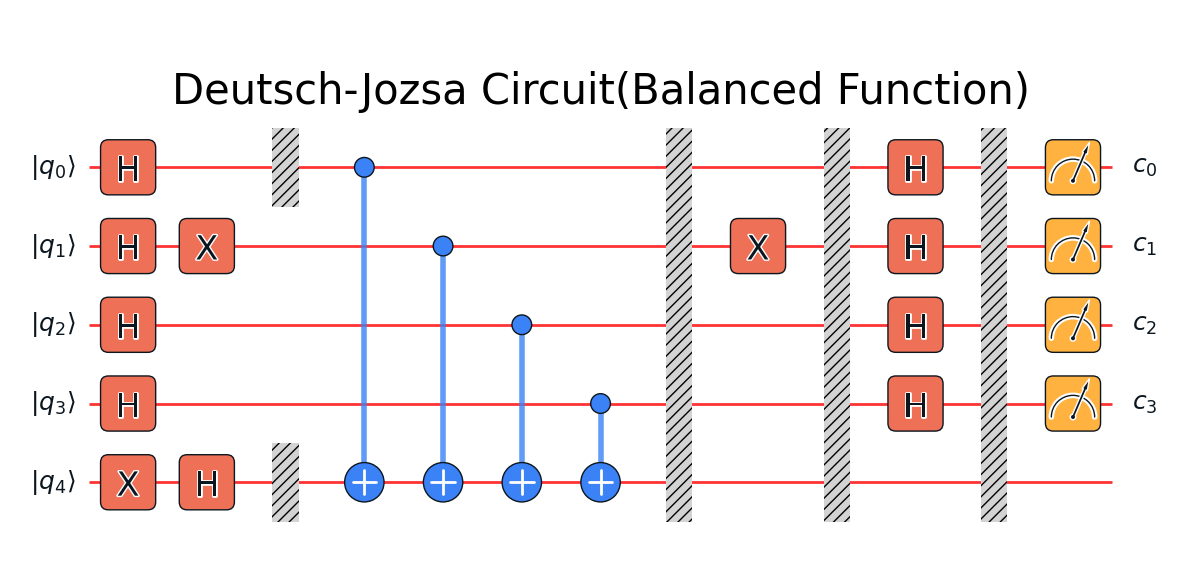

In [16]:
circuits = deutsch_jozsa(n=4, case='balanced')
circuits.plot_circuit(title='Deutsch-Jozsa Circuit(Balanced Function)')

下面函数调用实验装置计算并绘制结果：

In [23]:
def experi_demo(n: int, case: str):
    circuit = deutsch_jozsa(n, case)
    
    shots_num = 2000
    backend = "ScQ-P18"
   
    task = Task()
    task.config(backend=backend, shots=shots_num, compile=True)

    results = task.send(circuit)
    results.plot_probabilities()

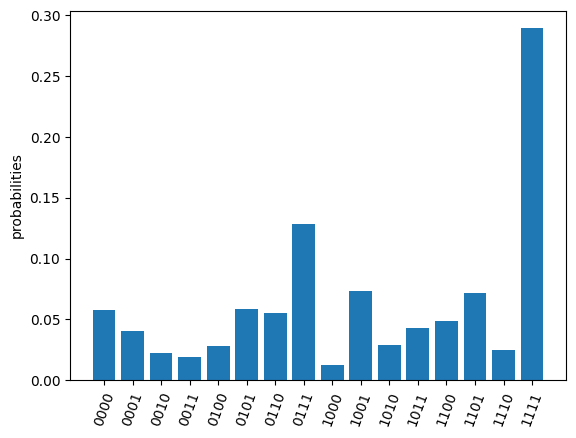

In [24]:
experi_demo(4, 'balanced')

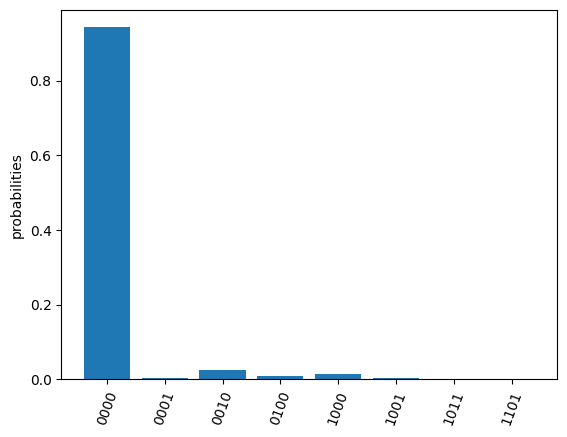

In [25]:
experi_demo(4, 'constant')

可以看到实验上存在的噪声等因素导致平衡线路下$0000$的振幅并不完全为$0$，但相比于常值线路区别仍十分明显。